### Investigating the elemental two-level time multigrid methods

We consider a fine level using $M$ points per blocks, associated to an integration operator $\phi$.
Then we associate it with a coarse level using $\tilde{M}$ points per blocks, associated to the integration
operator $\tilde{\phi}$ (same method as $\phi$, except but using less points per block).
For each level, we define approximate $\phi_\Delta$ and $\tilde{\phi}_\Delta$ methods, that use an approximate 
integration method (in comparison to the method used for $\phi$ and $\tilde{\phi}$.

Let recall the (old) denomination for the elemental two-level algorithms :

- STMG : use $\phi$ for relaxation on fine level, and $\tilde{\phi}$ for the coarse correction
- ATMG : use $\phi$ for relaxation on fine level, and $\tilde{\phi}_\Delta$ for the coarse correction
- TFASST : use $\phi_\Delta$ for relaxation on fine level, and $\tilde{\phi}$ for the coarse correction
- PFASST : use $\phi_\Delta$ for relaxation on fine level, and $\tilde{\phi}_\Delta$ for the coarse correction

The idea of this note is to investigate how the choices for integration operators impact the convergence of each elemental two-level methods.

In [1]:
# Script import setup
import numpy as np
import matplotlib.pyplot as plt
from gfm.base import GFMSolver
from gfm.util import setFig
plt.rcParams['figure.dpi'] = 100

Here we define a function that considers one problem and configuration ($\lambda$, $\Delta{t}$, $L$, ...) and run
all three elemental two-level methods. It plots :

1. accuracy of each integrator (considering a sequential time integration), with respect to the **exact** solution of the problem.
2. error of each two-level method after a given number of iterations, with respect to the **fine** sequential solution of the problem.

In [2]:
def runTwoGridMethods(lam, deltaMethod, fineMethod='COLLOCATION', M=9, MCoarse=3, u0=1, dt=0.5*np.pi, L=20):
    
    # Fixed setting parameters
    nodesType = 'LEGENDRE'
    qType = 'LOBATTO'
    
    # Initialize GFM solver
    s = GFMSolver(lam, u0, dt, L)
    s.setFineLevel(M=M, method=fineMethod, nodes=nodesType, qType=qType)
    s.setPhiDelta(deltaMethod)
    s.setCoarseLevel(MCoarse, nodes=nodesType, qType=qType)
    s.setPhiDeltaCoarse(deltaMethod)
    
    # Get sequential solutions to compare method and level accuracy
    t, uExact = s.getU('Exact', times=True)
    uFine = s.getU('Fine')
    uDelta = s.getU('Delta')
    tCoarse, uExactCoarse = s.getU('ExactCoarse', times=True)
    uCoarse = s.getU('Coarse')
    uDeltaCoarse = s.getU('DeltaCoarse')
    
    # Plot errors versus exact solution
    figSize = (12, 4)
    plt.subplot(1, 2, 1)
    plt.semilogy(# Fine level solution
        t, np.abs(uFine-uExact), 'o-', label=f'Fine ($M={M}$)')
    plt.semilogy(# Delta solution on fine level
        t, np.abs(uDelta-uExact), '--', label=f'Delta, {deltaMethod}')
    plt.semilogy(# Coarse level solution
        tCoarse, np.abs(uCoarse-uExactCoarse), 's-', label=r'Coarse ($\tilde{M}='+f'{MCoarse}$)')
    plt.semilogy(# Delta coarse level solution
        tCoarse, np.abs(uDeltaCoarse-uExactCoarse), '-.',
        label=f'Delta coarse, {deltaMethod}')
    plt.vlines(
        [0] + list(s.times[:, -1]), *plt.ylim(), colors='gray', linewidth=0.2)
    plt.hlines([1], 0, s.tEnd, colors='gray', linewidth=0.5)
    setFig('Time', 'Error vs exact solution', grid=False, figSize=figSize)
    
    # Fixed simulation parameters
    iType = 'RAND'
    nIter = 3
    nPreRelax = 1
    
    # Run all algorithms
    uTFASST = s.getInitU(iType)
    for k in range(nIter):
        s.iterate(
            'TwoGrid', uTFASST, approxCoarse=False, approxSmoother=True,
            nPreRelax=nPreRelax)
    uTFASST = s.getU(uTFASST)

    uATMG = s.getInitU(iType)
    for k in range(nIter):
        s.iterate(
            'TwoGrid', uATMG, approxCoarse=True, approxSmoother=False,
            nPreRelax=nPreRelax)
    uATMG = s.getU(uATMG)

    uPFASST = s.getInitU(iType)
    for k in range(nIter):
        s.iterate(
            'TwoGrid', uPFASST, approxCoarse=True, approxSmoother=True,
            nPreRelax=nPreRelax)
    uPFASST = s.getU(uPFASST)

    uSTMG = s.getInitU(iType)
    for k in range(nIter):
        s.iterate(
            'TwoGrid', uSTMG, approxCoarse=False, approxSmoother=False,
            nPreRelax=nPreRelax)
    uSTMG = s.getU(uSTMG)
    
    # Plot error versus sequential solution
    plt.subplot(1, 2, 2)
    plt.semilogy(t, np.abs(uSTMG-uFine), label='STMG')
    plt.semilogy(t, np.abs(uPFASST-uFine), label='PFASST')
    plt.semilogy(t, np.abs(uATMG-uFine), '--', label='ATMG')
    plt.semilogy(t, np.abs(uTFASST-uFine), '-.', label='TFASST')
    plt.vlines(s.times[:, -1], *plt.ylim(), colors='gray', linewidth=0.2)
    setFig('Time', 'Error vs fine solution', f'After {nIter} iterations',
           grid=False, figSize=figSize)

Now we run it for different values of $\lambda$ and different types of delta operators :

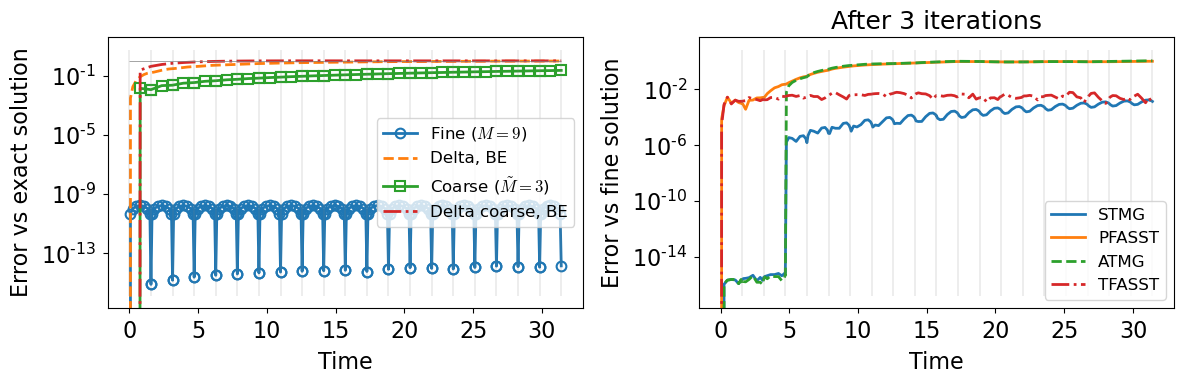

In [3]:
runTwoGridMethods(lam=1j, deltaMethod='BE')

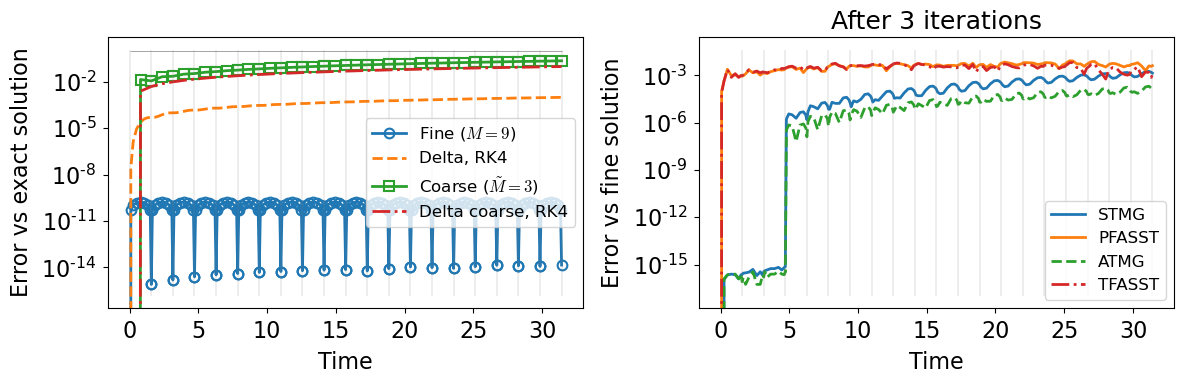

In [4]:
runTwoGridMethods(lam=1j, deltaMethod='RK4')

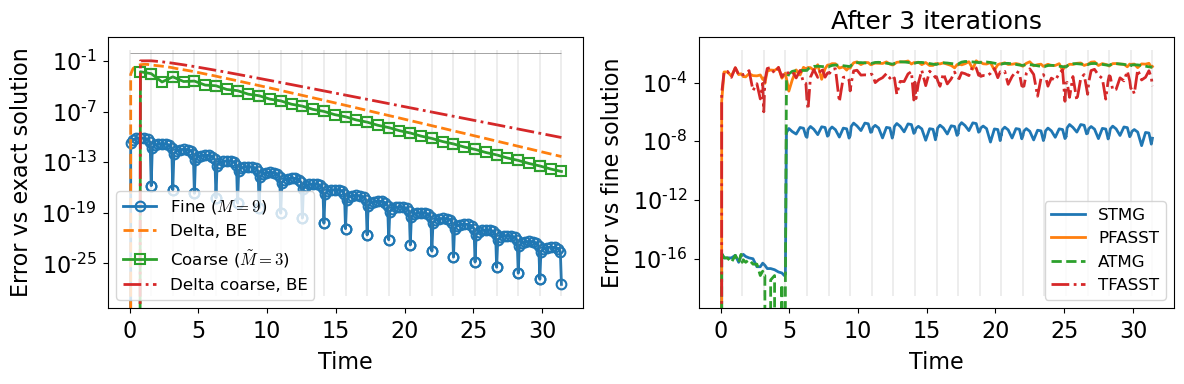

In [5]:
runTwoGridMethods(lam=-1, deltaMethod='BE')

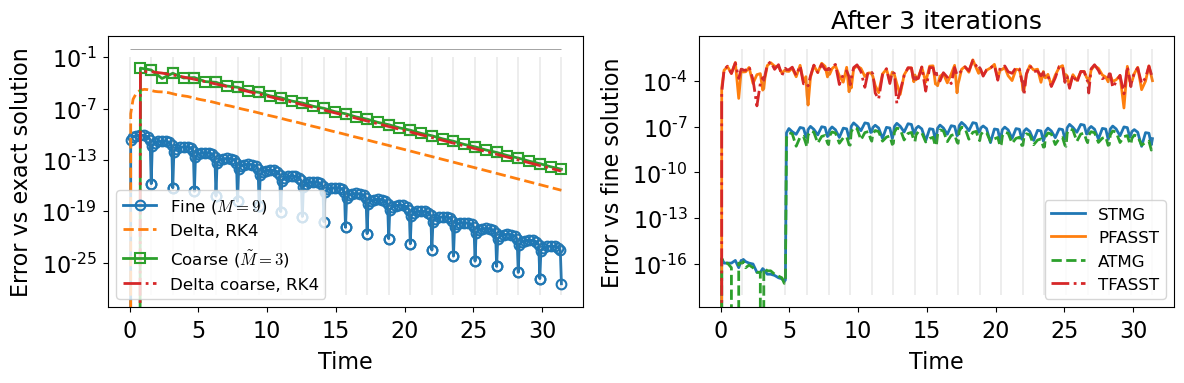

In [6]:
runTwoGridMethods(lam=-1, deltaMethod='RK4')